In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightkurve import LightCurve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')


In [24]:
# Load the dataset
kiodata = pd.read_csv('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/datasets/kio_cumulative_2025.10.04_03.15.13.csv')
tessdata = pd.read_csv('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/datasets/Tess_TOI_2025.10.04_03.15.57.csv')

# For simplicity, we'll focus on the kiodata as it's rich and well-documented.
df = kiodata.copy()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_time0bk        9564 non-null   float64
 12  koi_impact         9201 non-null   float64
 13  koi_duration       9564 non-null   float64
 14  koi_depth          9201 non-null   float64
 15  koi_prad           9201 non-null   float64
 16  koi_teq            9201 

In [25]:
# Preprocessing
# For the target variable 'koi_disposition', we are interested in finding exoplanets.
# We will consider 'CONFIRMED' and 'CANDIDATE' as exoplanets (1) and 'FALSE POSITIVE' as not (0).
df['koi_disposition'] = df['koi_disposition'].apply(lambda x: 1 if x in ['CONFIRMED', 'CANDIDATE'] else 0)

# Dropping columns that are not useful for prediction or have too many missing values.
# We will also drop 'kepler_name', 'koi_teq_err1', 'koi_teq_err2' as they are not direct features.
# We will also drop error columns for now to simplify the model.
cols_to_drop = [col for col in df.columns if 'err' in col or 'str' in col]
df = df.drop(columns=['kepler_name', 'kepid', 'koi_pdisposition', 'koi_score', 'koi_tce_delivname'] + cols_to_drop, errors='ignore')

# For simplicity, we will fill missing values with the median of the column.
for col in df.columns:
    if df[col].dtype != 'object':
        df[col].fillna(df[col].median(), inplace=True)

# Drop remaining object columns that are not features, ignoring if they don't exist
extra_cols_to_drop = [
    'koi_comment', 'koi_trans_mod', 'koi_time0bk_str', 'koi_period_str',
    'koi_duration_str', 'koi_depth_str', 'koi_impact_str', 'koi_insol_str',
    'koi_steff_str', 'koi_slogg_str', 'koi_srad_str'
]
df = df.drop(columns=extra_cols_to_drop, errors='ignore')

# Display the cleaned data info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   kepoi_name        9564 non-null   object 
 1   koi_disposition   9564 non-null   int64  
 2   koi_fpflag_nt     9564 non-null   int64  
 3   koi_fpflag_ss     9564 non-null   int64  
 4   koi_fpflag_co     9564 non-null   int64  
 5   koi_fpflag_ec     9564 non-null   int64  
 6   koi_period        9564 non-null   float64
 7   koi_time0bk       9564 non-null   float64
 8   koi_impact        9564 non-null   float64
 9   koi_duration      9564 non-null   float64
 10  koi_depth         9564 non-null   float64
 11  koi_prad          9564 non-null   float64
 12  koi_teq           9564 non-null   float64
 13  koi_insol         9564 non-null   float64
 14  koi_model_snr     9564 non-null   float64
 15  koi_tce_plnt_num  9564 non-null   float64
 16  koi_steff         9564 non-null   float64


In [26]:
from sklearn.feature_selection import SelectKBest, f_classif

# Feature Selection
# Remove non-numeric columns before feature selection
X = df.drop(['koi_disposition', 'kepoi_name'], axis=1)
y = df['koi_disposition']

# Select the top 20 features
selector = SelectKBest(f_classif, k=20)
X_new = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

# Create a new dataframe with the selected features
df_selected = pd.DataFrame(X_new, columns=selected_features)
df_selected['koi_disposition'] = y.values


Selected features: Index(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
       'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth',
       'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num',
       'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag'],
      dtype='object')


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Data Splitting and Scaling
X_train, X_test, y_train, y_test = train_test_split(df_selected.drop('koi_disposition', axis=1), df_selected['koi_disposition'], test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


Epoch 1/50
192/192 - 2s - 12ms/step - accuracy: 0.8441 - loss: 0.4001 - val_accuracy: 0.8733 - val_loss: 0.2926
Epoch 2/50
192/192 - 2s - 12ms/step - accuracy: 0.8441 - loss: 0.4001 - val_accuracy: 0.8733 - val_loss: 0.2926
Epoch 2/50
192/192 - 2s - 9ms/step - accuracy: 0.8830 - loss: 0.3725 - val_accuracy: 0.8772 - val_loss: 0.2599
Epoch 3/50
192/192 - 2s - 9ms/step - accuracy: 0.8830 - loss: 0.3725 - val_accuracy: 0.8772 - val_loss: 0.2599
Epoch 3/50
192/192 - 2s - 9ms/step - accuracy: 0.9002 - loss: 0.3923 - val_accuracy: 0.8955 - val_loss: 0.2359
Epoch 4/50
192/192 - 2s - 9ms/step - accuracy: 0.9002 - loss: 0.3923 - val_accuracy: 0.8955 - val_loss: 0.2359
Epoch 4/50
192/192 - 2s - 9ms/step - accuracy: 0.8992 - loss: 0.3795 - val_accuracy: 0.9066 - val_loss: 0.2191
Epoch 5/50
192/192 - 2s - 9ms/step - accuracy: 0.8992 - loss: 0.3795 - val_accuracy: 0.9066 - val_loss: 0.2191
Epoch 5/50
192/192 - 2s - 9ms/step - accuracy: 0.9114 - loss: 0.3614 - val_accuracy: 0.9092 - val_loss: 0.2033

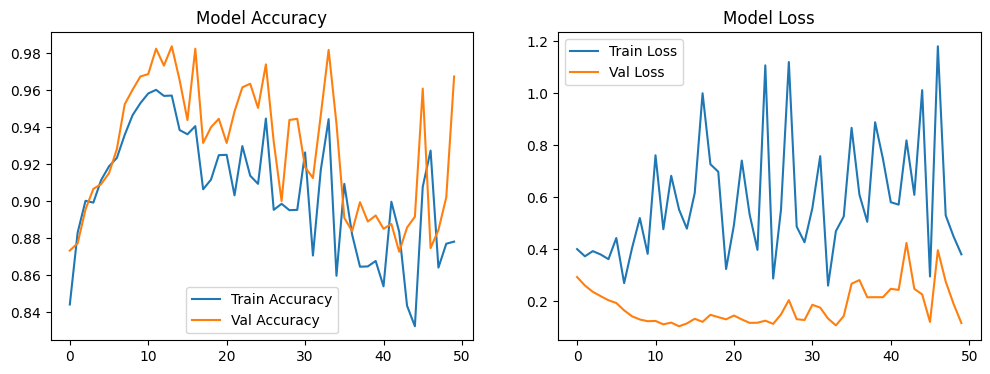

In [28]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the Deep Learning model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.savefig('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/results/training_history.png')
plt.show()


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       939
           1       0.95      0.99      0.97       974

    accuracy                           0.97      1913
   macro avg       0.97      0.97      0.97      1913
weighted avg       0.97      0.97      0.97      1913

ROC AUC Score: 0.9930
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       939
           1       0.95      0.99      0.97       974

    accuracy                           0.97      1913
   macro avg       0.97      0.97      0.97      1913
weighted avg       0.97      0.97      0.97      1913

ROC AUC Score: 0.9930


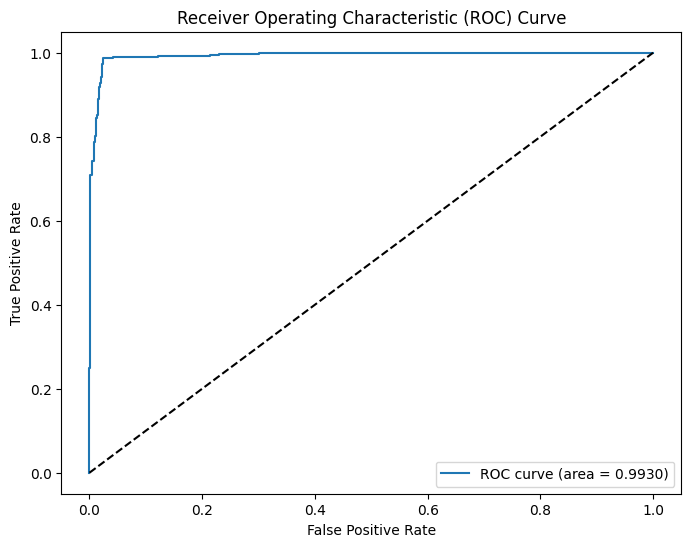

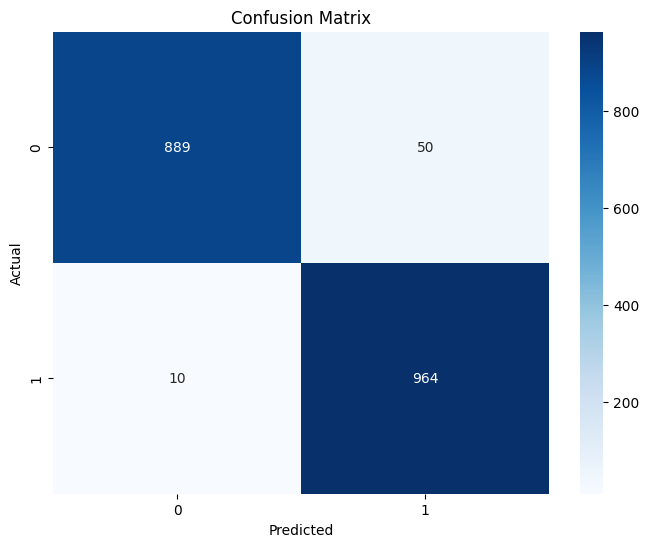

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predictions
y_pred_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")
#plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc_score(y_test, y_pred_proba):.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/results/roc_curve_DL.png')
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/results/confusion_matrix_DL.png')
plt.show()


In [30]:
import joblib
import json

# Save the model
model.save('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/exoplanet_model_DL_dataset.h5')

# Save the scaler
joblib.dump(scaler, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/scaler_DL_dataset.pkl')

# Save the selected features
with open('/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/notebooks/models/selected_features_DL_dataset.json', 'w') as f:
    json.dump(selected_features.tolist(), f)

print("Model, scaler, and features saved successfully.")


Model, scaler, and features saved successfully.
